# Taiwanese Food 101 Classification with Deep Learning in Keras
In this experiment, we use Taiwanese-Food-101 Dataset to implement image classfication and compare with different famous model.
***

## Loading and Preprocessing Dataset
Import all of the packages we needed to use.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras.layers.core import Dense, Flatten
from keras.layers import Dropout
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.models import Model
import os
import numpy as np
from keras.models import load_model

def acc_top5(y_true, y_pred):
    return keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=5)

## Let's look at some random images from each food class
---

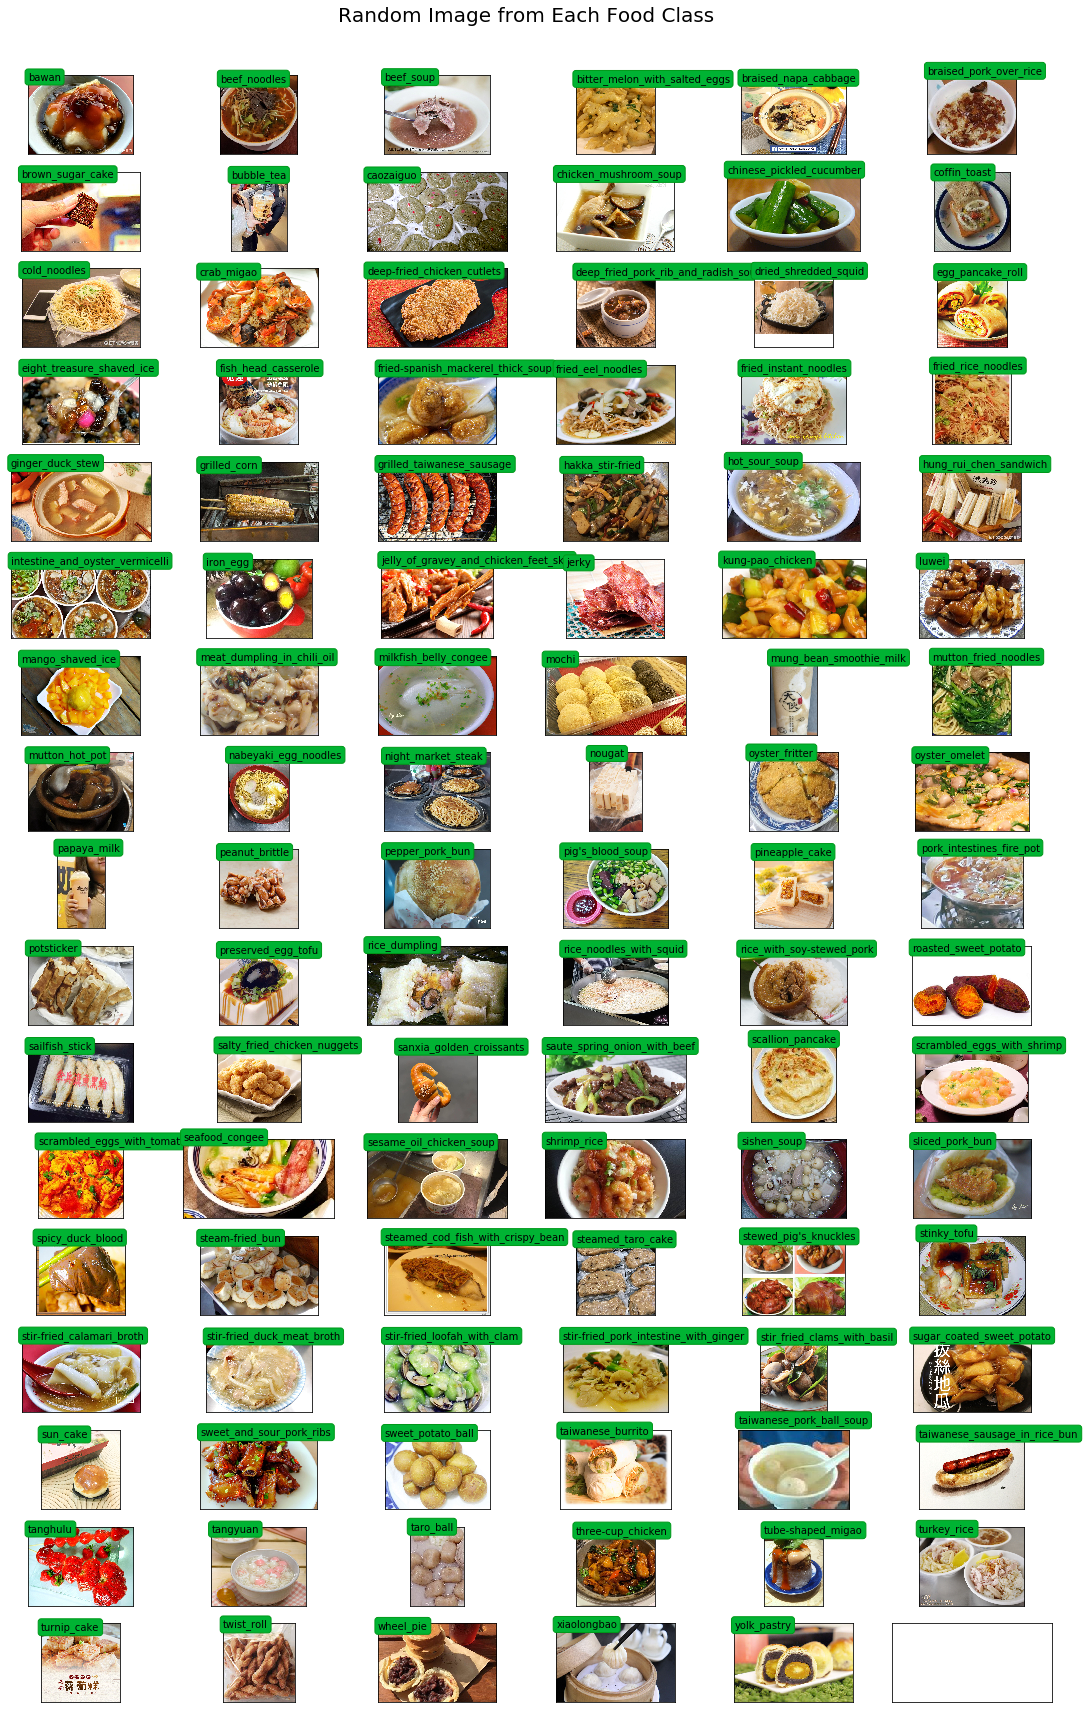

In [6]:
root_dir = 'D:/Datasets/Food101&TaiwaneseDish/Taiwanese Food 101/images'
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, frameon=False, figsize=(15, 25))
fig.suptitle('Random Image from Each Food Class', fontsize=20)
sorted_food_dirs = sorted(os.listdir(root_dir))
for i in range(rows):
    for j in range(cols):
        try:
            food_dir = sorted_food_dirs[i*cols + j]
        except:
            break
        all_files = os.listdir(os.path.join(root_dir, food_dir))
        rand_img = np.random.choice(all_files)
        img = plt.imread(os.path.join(root_dir, food_dir, rand_img))
        ax[i][j].imshow(img)
        ec = (0, .6, .1)
        fc = (0, .7, .2)
        ax[i][j].text(0, -20, food_dir, size=10, rotation=0,
                ha="left", va="top", 
                bbox=dict(boxstyle="round", ec=ec, fc=fc))
plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

## Use ImageDataGenerator to load image
***

In [2]:
train_path = "D:/Datasets/Food101&TaiwaneseDish/TaiwaneseDish_train/"
valid_path = "D:/Datasets/Food101&TaiwaneseDish/TaiwaneseDish_validation/"
test_path = "D:/Datasets/Food101&TaiwaneseDish/TaiwaneseDish_test/"


train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [3]:
train_generator = train_datagen.flow_from_directory(
    train_path,  
    target_size=(150, 150), 
    color_mode = "rgb",
    batch_size=8,
    class_mode='categorical',
    shuffle = True,
    seed = 42 )

valid_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=(150, 150),
    batch_size=8,
    class_mode='categorical',
    color_mode = "rgb"
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size =(150, 150),
    color_mode ="rgb",
    batch_size = 1,
    class_mode = None,
    shuffle = False
)

Found 10100 images belonging to 101 classes.
Found 5050 images belonging to 101 classes.
Found 5050 images belonging to 101 classes.


## Use different famous model to train model
* DenseNet
* Inception
* VGG
* ResNet
* MobileNet

You can import all model I used in Keras.

### Build model

In [11]:
base_model = keras.applications.densenet.DenseNet121(include_top=False, weights='imagenet', input_shape=(150, 150, 3))
#base_model = keras.applications.inception_v3.InceptionV3(include_top=False, weights='imagenet', input_shape=(150, 150, 3))
#base_model = keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(150, 150, 3))
#base_model = keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(150, 150, 3))
#base_model = keras.applications.mobilenet.MobileNet(include_top=False, weights='imagenet', input_shape=(150, 150, 3))

In [14]:
x = base_model.output
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(.5)(x)

predictions = Dense(101, activation='softmax')(x)

model = Model(input=base_model.input, output=predictions)

C:\Users\User\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  if __name__ == '__main__':


In [15]:
model.compile(Adam(lr=.00002122),
                  loss='categorical_crossentropy', 
                  metrics=['accuracy', acc_top5])

### Training model

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

filepath="D:/Datasets/Food101&TaiwaneseDish/Model/Taiwanese Dish model/20200412_v1.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max', save_weights_only=False)
es = EarlyStopping(monitor='val_acc', patience=20, verbose=0, mode='auto')

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size 
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size

history = model.fit_generator(
      train_generator,
      steps_per_epoch=STEP_SIZE_TRAIN,
      epochs=100,
      validation_data=valid_generator,
      validation_steps=STEP_SIZE_VALID,
      callbacks=[es, checkpoint]
)

## Evaluate Model
***
Use testing data to evaluate the accuracy of the model.

### Load model

In [16]:
filepath = "D:/Datasets/Food101&TaiwaneseDish/Taiwanese Food 101/DenseNet121.h5"
model = load_model(filepath, custom_objects={'acc_top5':acc_top5})

### Predict result

In [ ]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
pred=model.predict_generator(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

### Change probibility to classes

In [ ]:
predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator.class_indices)
print(labels)
labels = dict((v,k) for k,v in labels.items())
results = [labels[k] for k in predicted_class_indices]

### Create labels list

In [30]:
filepath = "D:/Datasets/Food101&TaiwaneseDish/TaiwaneseDish_validation"
test_filepath = os.listdir(filepath)
test_filepath.sort() 
    
labels = []
for i in range(len(test_filepath)):
    for a in range(50):
        labels.append(test_filepath[i]) 

### Calculate accuracy

In [31]:
acc=0
for i in range(5050):
    if results[i]==labels[i]:
            acc=acc+1

print("Accuracy:",acc/5050)

Accuracy: 0.7833663366336634
